In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


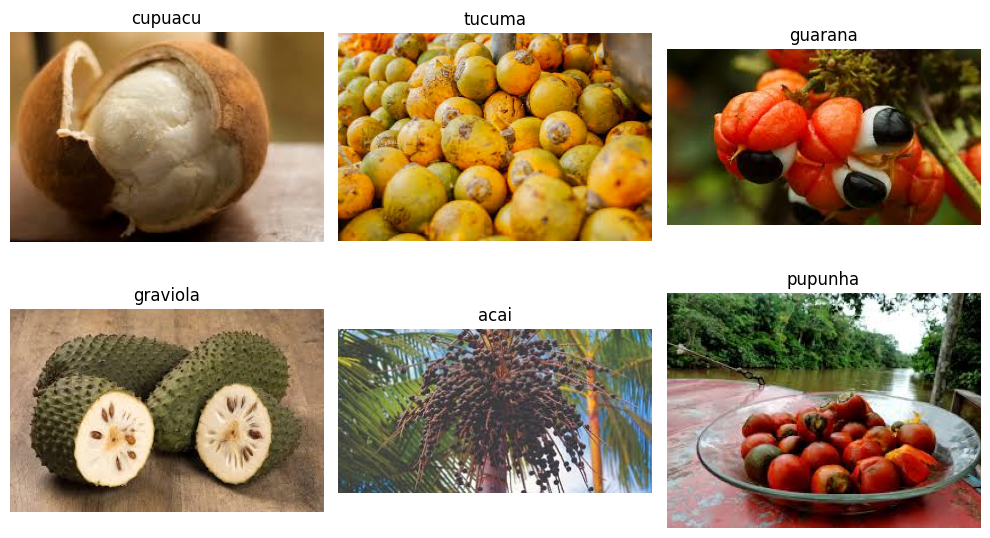

In [2]:
import os
import random
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
from matplotlib.image import imread

#directory containing training images
train_directory = '/content/drive/MyDrive/FruitinAmazon/train'

#retrieve the list of class directories
class_folders = [folder for folder in os.listdir(train_directory) if os.path.isdir(os.path.join(train_directory, folder))]

#selecting one random image from each class
chosen_images =[]
for folder in class_folders:
  folder_path = os.path.join(train_directory, folder)
  image_files = [img for img in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, img))]
  if image_files:
    selected_image = random.choice(image_files)
    chosen_images.append((folder, os.path.join(folder_path, selected_image)))

#display selected image in a grid format with two rows
num_classes = len(chosen_images)
fig , axes = plt.subplots(2, (num_classes + 1 ) // 2, figsize = (10, 6))
axes = axes.flatten()

for ax, (class_name, image_path) in zip(axes, chosen_images):
  image = imread(image_path)
  ax.imshow(image)
  ax.set_title(class_name)
  ax.axis('off')
#hide any ramaining empty sublots
for ax in axes[len(chosen_images):]:
  ax.axis('off')
plt.tight_layout()
plt.show()


In [3]:
import tensorflow as tf
import keras
image_size = (28, 28)
batch_size = 32
train_ds, val_ds = keras.utils.image_dataset_from_directory(
train_directory,
validation_split=0.2,
subset="both",
seed=1337,
image_size=image_size,
batch_size=batch_size,
)

Found 90 files belonging to 6 classes.
Using 72 files for training.
Using 18 files for validation.


In [4]:
for images, labels in train_ds.take(1): # Take one batch
  print("Images shape:", images.shape)
  print("Labels shape:", labels.shape)

Images shape: (32, 28, 28, 3)
Labels shape: (32,)


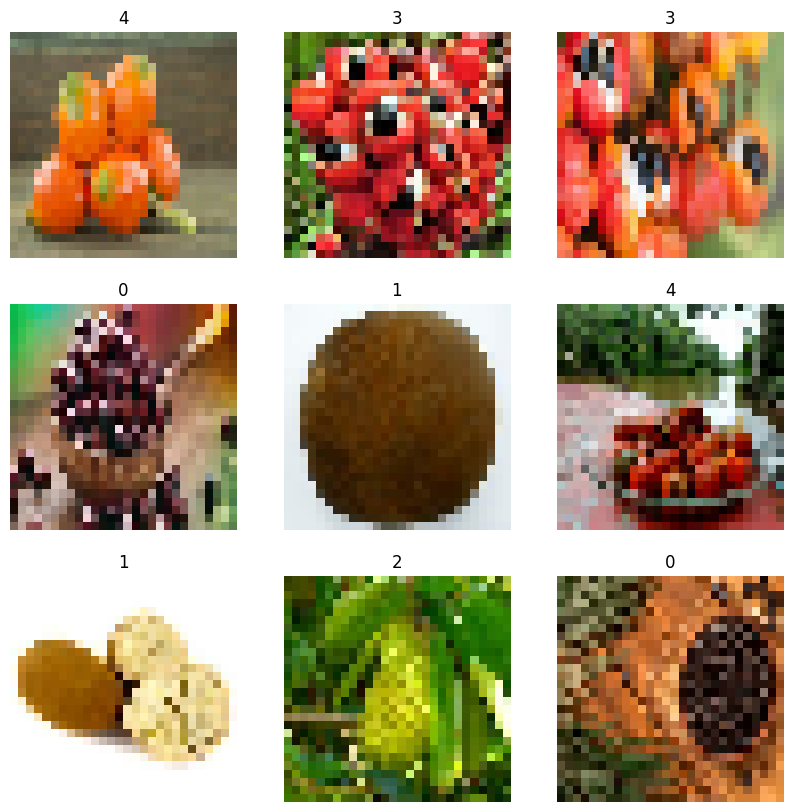

In [5]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1): #Takes one batch of images from the dataset (train_ds).
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(np.array(images[i]).astype("uint8"))
    plt.title(int(labels[i]))
    plt.axis("off")

Found 90 files belonging to 6 classes.
Found 30 files belonging to 6 classes.


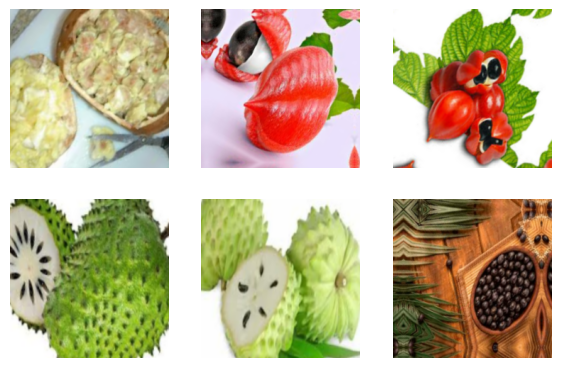

In [6]:
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt

# Define image size and batch size
img_size = (224, 224)
batch_size = 32

# Load train and test datasets
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_directory,
    shuffle=True,
    image_size=img_size,
    batch_size=batch_size  # Corrected parameter name
)

test_directory = '/content/drive/MyDrive/FruitinAmazon/test'
test_dataset = tf.keras.utils.image_dataset_from_directory(
    test_directory,
    shuffle=False,
    image_size=img_size,
    batch_size=batch_size  # Corrected parameter name
)

# Define data augmentation
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.2),
])

# Visualizing augmented images
def visualization(dataset):
    plt.figure(figsize=(7, 7))

    for images, _ in dataset.take(1):  # Take one batch
        for i in range(6):  # Show 6 images
            image = tf.expand_dims(images[i], axis=0)  # Expand dimensions to match batch format
            augmented_img = data_augmentation(image)  # Apply augmentation
            augmented_img = tf.squeeze(augmented_img)  # Remove batch dimension

            plt.subplot(3, 3, i + 1)
            plt.imshow(augmented_img.numpy().astype("uint8"))
            plt.axis("off")

    plt.show()

# Call the function (must be outside the function definition)
visualization(train_dataset)

In [7]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation, Lambda, Rescaling
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import numpy as np

data_augmentation_layers = [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
]

def data_augmentation(images):
    for layer in data_augmentation_layers:
        images = layer(images)
    return images

# Define the model using the Sequential API with a list of layers
model = Sequential([
    # Data augmentation applied using Lambda layer
    layers.Lambda(data_augmentation, input_shape=(224, 224, 3)),
    # Rescaling layer to normalize pixel values
    layers.Rescaling(1./255),
    # First Convolutional Block
    Conv2D(32, (3, 3), padding='same', activation=None),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    # Second Convolutional Block
    Conv2D(64, (3, 3), padding='same', activation=None),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    # Third Convolutional Block
    Conv2D(128, (3, 3), padding='same', activation=None),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    # Fourth Convolutional Block
    Conv2D(256, (3, 3), padding='same', activation=None),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    # Flatten the output of the last Conv2D layer
    Flatten(),
    # First Fully Connected Layer
    Dense(512, activation=None),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.5),
    # Second Fully Connected Layer
    Dense(256, activation=None),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.5),
    # Third Fully Connected Layer
    Dense(128, activation=None),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.5),
    # Fourth Fully Connected Layer
    Dense(64, activation=None),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.5),
    # Output Layer with 10 neurons (for classification task with 10 classes)
    Dense(10, activation='softmax')
])

# Compile the model with Adam optimizer, sparse categorical crossentropy loss, and accuracy as the metric
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',  # Use this for integer labels
              metrics=['accuracy'])


# Summary of the model
model.summary()

checkpoint = ModelCheckpoint(
    'best_model.keras',  # Save best model
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=20,  # Stop after 20 epochs with no improvement
    mode='max',
    verbose=1
)
# Train model
histroy = model.fit(
    train_dataset,
    epochs=250,
    validation_data=test_dataset,
    callbacks=[checkpoint, early_stopping]
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/lambda_layer.py:65: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lambda (Lambda)                      │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling (Rescaling)                │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 224, 224, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 224, 224, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 224, 224, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 112, 112, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 112, 112, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 56, 56, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 56, 56, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 28, 28, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 28, 28, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 26,257,930 (100.17 MB)

 Trainable params: 26,255,050 (100.16 MB)

 Non-trainable params: 2,880 (11.25 KB)

Epoch 1/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.1174 - loss: 2.9201
Epoch 1: val_accuracy improved from -inf to 0.16667, saving model to best_model.keras
3/3 ━━━━━━━━━━━━━━━━━━━━ 50s 15s/step - accuracy: 0.1214 - loss: 2.8982 - val_accuracy: 0.1667 - val_loss: 2.2599
Epoch 2/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.0772 - loss: 3.1513
Epoch 2: val_accuracy did not improve from 0.16667
3/3 ━━━━━━━━━━━━━━━━━━━━ 21s 7s/step - accuracy: 0.0885 - loss: 3.0937 - val_accuracy: 0.1667 - val_loss: 2.2434
Epoch 3/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.0906 - loss: 2.9394
Epoch 3: val_accuracy did not improve from 0.16667
3/3 ━━━━━━━━━━━━━━━━━━━━ 42s 7s/step - accuracy: 0.0930 - loss: 2.9224 - val_accuracy: 0.1667 - val_loss: 2.2338
Epoch 4/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.2051 - loss: 2.6783
Epoch 4: val_accuracy did not improve from 0.16667
3/3 ━━━━━━━━━━━━━━━━━━━━ 42s 8s/step - accuracy: 0.1983 - loss: 2.6832 - val_accuracy: 0.1667

In [9]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import numpy as np

# Load VGG16 base model (without top, pretrained on ImageNet)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze all convolutional layers

# Add custom head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(10, activation='softmax')(x)

# Create model (this was the part that broke)
model = Model(inputs=base_model.input, outputs=predictions)

# NOW we compile it (without any misplaced arguments)
model.compile(
    optimizer=Adam(),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks
checkpoint = ModelCheckpoint(
    'vgg16_best_model.keras',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    mode='max',
    verbose=1
)

# Train
history = model.fit(
    train_dataset,
    epochs=20,
    validation_data=test_dataset,
    callbacks=[checkpoint, early_stopping]
)


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16s/step - accuracy: 0.0787 - loss: 17.9855 
Epoch 1: val_accuracy improved from -inf to 0.26667, saving model to vgg16_best_model.keras
3/3 ━━━━━━━━━━━━━━━━━━━━ 69s 25s/step - accuracy: 0.0868 - loss: 17.2364 - val_accuracy: 0.2667 - val_loss: 2.9104
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16s/step - accuracy: 0.1263 - loss: 10.1600 
Epoch 2: val_accuracy improved from 0.26667 to 0.40000, saving model to vgg16_best_model.keras
3/3 ━━━━━━━━━━━━━━━━━━━━ 86s 26s/step - accuracy: 0.1308 - loss: 9.9538 - val_accuracy: 0.4000 - val_loss: 2.0716
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16s/step - accuracy: 0.3061 - loss: 6.7076 
Epoch 3: val_accuracy did not improve from 0.40000
3/3 ━━━━━━━━━━━━━━━━━━━━ 80s 26s/step - accuracy: 0.2990 - loss: 6.7433 - val_accuracy: 0.4000 - val_loss: 2.1382
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16s/step - accuracy: 0.2525 - loss: 6.4612 
Epoch 4: val_accuracy improved fro

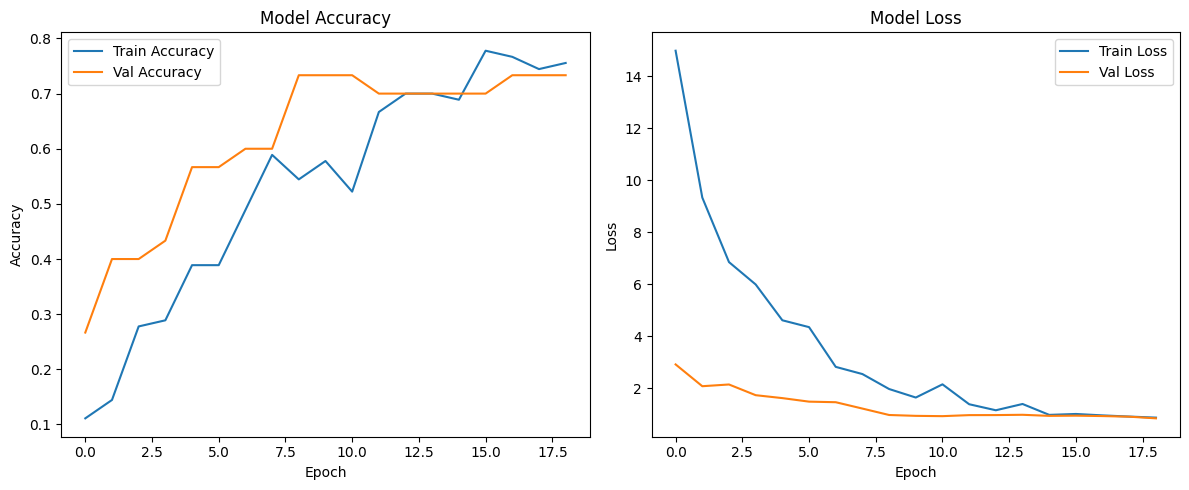

In [10]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [11]:
from sklearn.metrics import classification_report
import numpy as np

# Get predictions
y_true = np.concatenate([y for _, y in test_dataset], axis=0)
y_pred_probs = model.predict(test_dataset)
y_pred = np.argmax(y_pred_probs, axis=1)

# Report
print(classification_report(y_true, y_pred))


1/1 ━━━━━━━━━━━━━━━━━━━━ 17s 17s/step
              precision    recall  f1-score   support

           0       0.83      1.00      0.91         5
           1       0.80      0.80      0.80         5
           2       1.00      0.80      0.89         5
           3       0.83      1.00      0.91         5
           4       1.00      0.20      0.33         5
           5       0.38      0.60      0.46         5

    accuracy                           0.73        30
   macro avg       0.81      0.73      0.72        30
weighted avg       0.81      0.73      0.72        30

